
Price = 25
Time Slot 1 (08:00 - 11:00)
  Original Arrival Rate: 15.00 cars/hour
  Changed Arrival Rate: 15.00 cars/hour
Time Slot 2 (12:00 - 16:00)
  Original Arrival Rate: 50.00 cars/hour
  Changed Arrival Rate: 50.00 cars/hour
Time Slot 3 (17:00 - 20:00)
  Original Arrival Rate: 50.00 cars/hour
  Changed Arrival Rate: 50.00 cars/hour


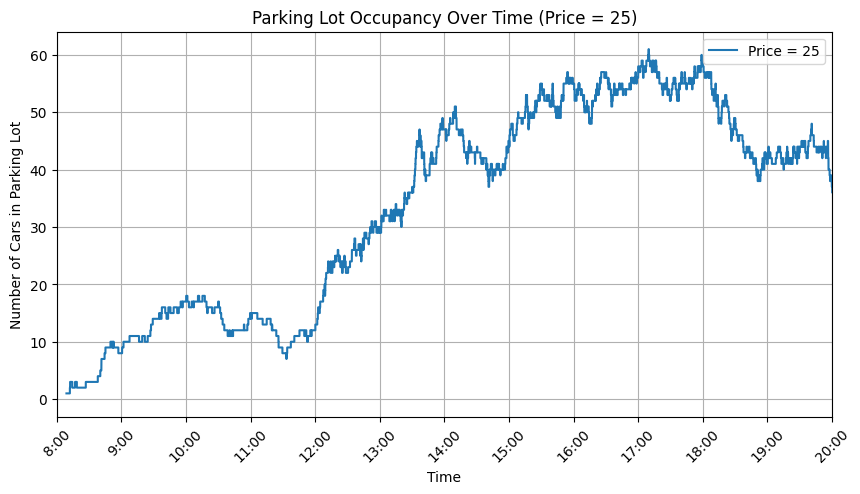

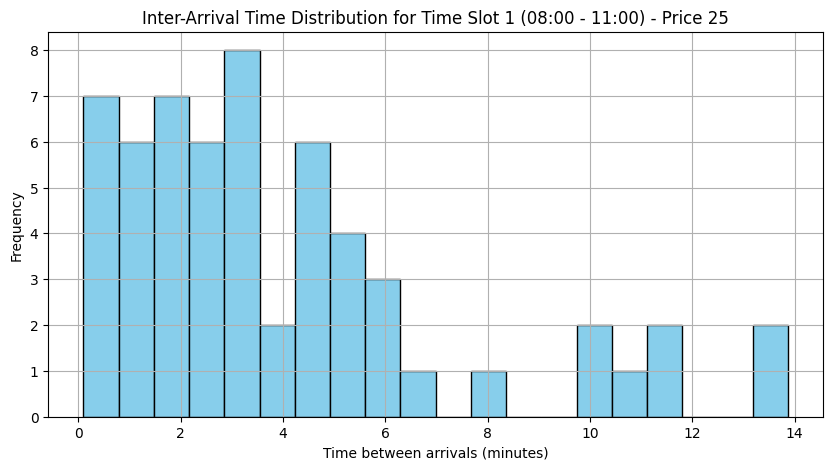

Average inter-arrival time for slot 1 at price 25: 3.99 minutes


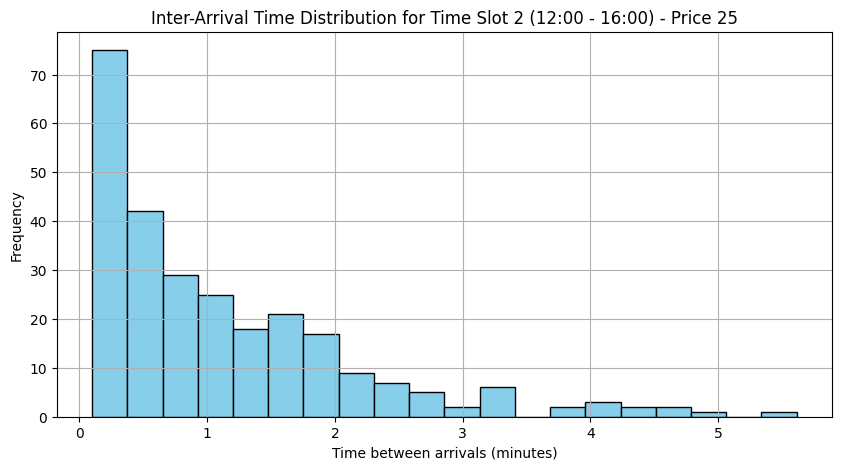

Average inter-arrival time for slot 2 at price 25: 1.12 minutes


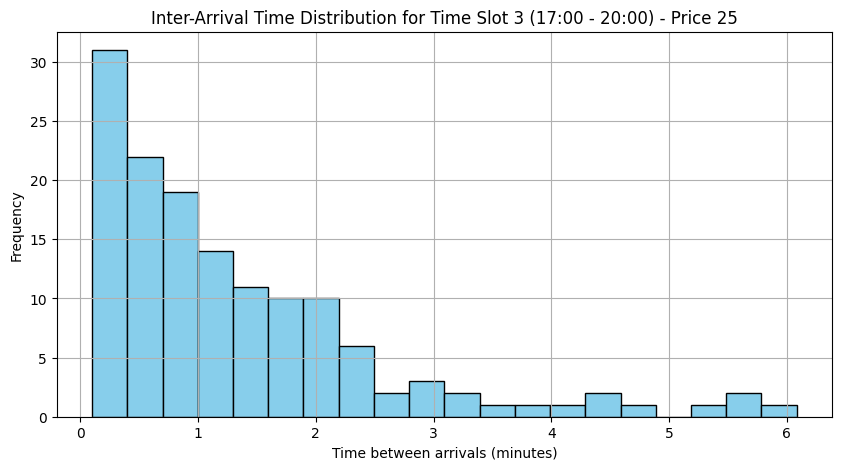

Average inter-arrival time for slot 3 at price 25: 1.32 minutes


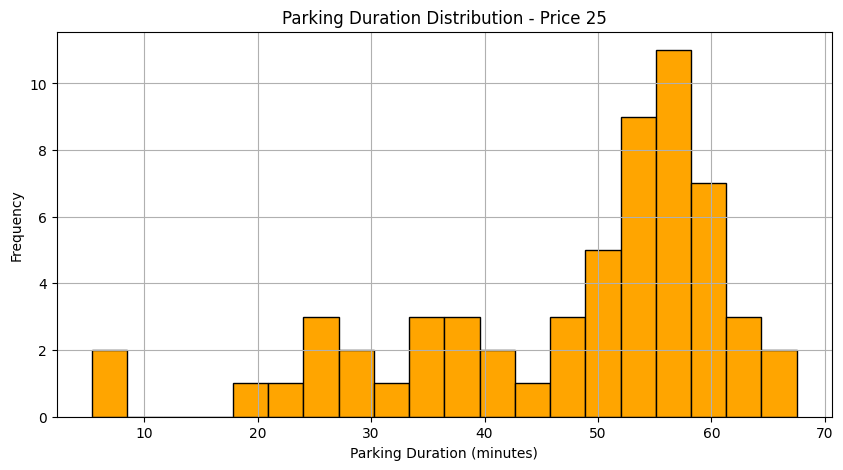

Number of lost customers at price 25: 0

Price = 15
Time Slot 1 (08:00 - 11:00)
  Original Arrival Rate: 15.00 cars/hour
  Changed Arrival Rate: 17.38 cars/hour
Time Slot 2 (12:00 - 16:00)
  Original Arrival Rate: 50.00 cars/hour
  Changed Arrival Rate: 57.94 cars/hour
Time Slot 3 (17:00 - 20:00)
  Original Arrival Rate: 50.00 cars/hour
  Changed Arrival Rate: 57.94 cars/hour


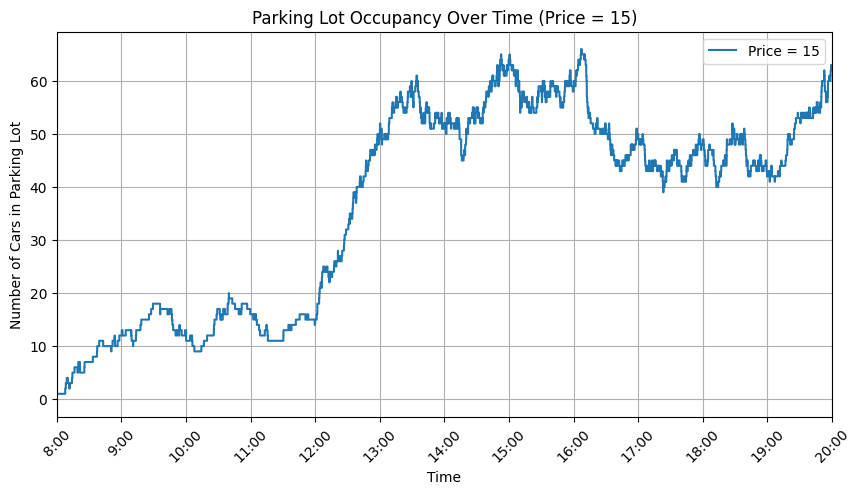

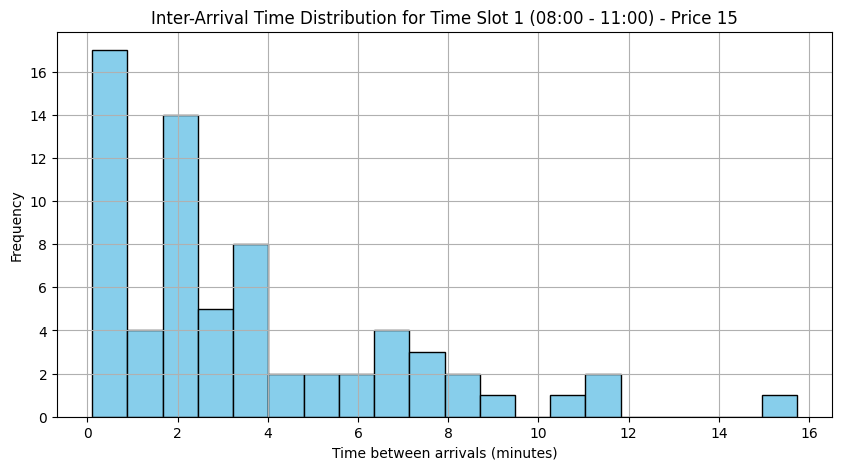

Average inter-arrival time for slot 1 at price 15: 3.52 minutes


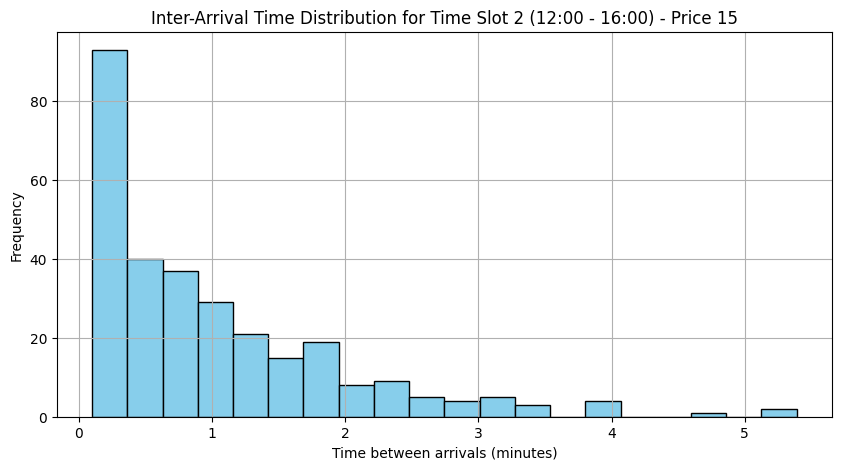

Average inter-arrival time for slot 2 at price 15: 1.01 minutes


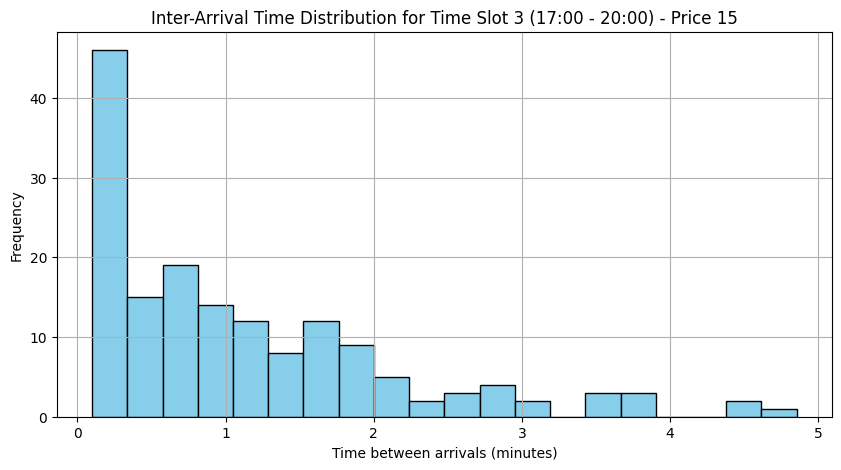

Average inter-arrival time for slot 3 at price 15: 1.11 minutes


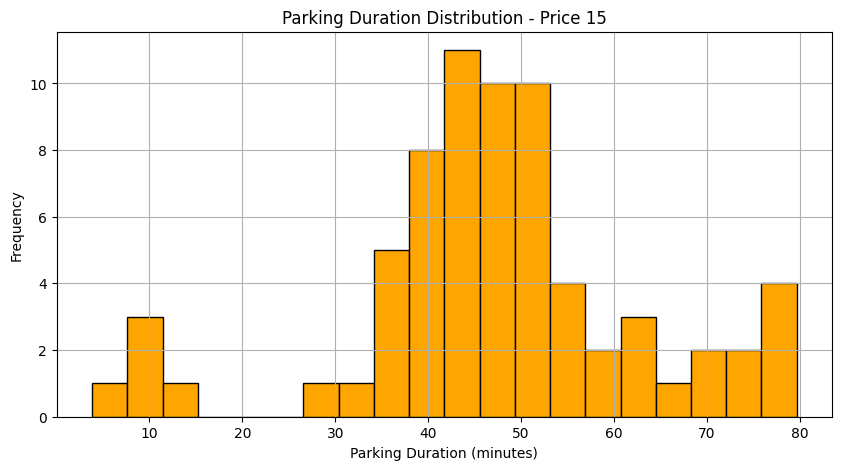

Number of lost customers at price 15: 0


In [17]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# Define arrival rates for specific time slots (in cars per minute)
time_slots = [
    (8 * 60, 11 * 60 + 59, 15 / 60),   # 08:00 - 11:59 (15 cars/hour)
    (12 * 60, 16 * 60 + 59, 50 / 60),  # 12:00 - 16:59 (50 cars/hour)
    (17 * 60, 20 * 60, 50 / 60)        # 17:00 - 20:00 (50 cars/hour)
]

# Define simulation parameters
PARKING_SPACES = 250          # Number of parking spaces in the lot
SIMULATION_TIME = 12 * 60 * 60  # Simulation time for 12 hours
PARKING_DURATION_MEAN = 59     # Average time a car spends parked (in minutes)

# Data storage
arrival_times = {i: [] for i in range(len(time_slots))}
departure_times = []
lost_customers = 0
parking_lot_occupancy = []

# Factors for adjusting lambda based on weather and price
base_wtv = 80                 # Base WTV (neutral)
price_sensitivity = -1.27      # Sensitivity of WTV to price changes (negative: higher price worsens WTV)
base_price = 25               # Base parking price

def calculate_wtv(current_price):
    """Calculate WTV based on the current price and sensitivity."""
    return base_wtv + price_sensitivity * (current_price - base_price)

def adjust_lambda(base_lambda, wtv):
    """Adjust base lambda using the calculated WTV."""
    return base_lambda * (wtv / base_wtv)

def get_current_lambda(current_time, current_price):
    """Determine the current lambda based on the simulated time and adjust with weather factors."""
    wtv = calculate_wtv(current_price)
    for i, (start, end, rate) in enumerate(time_slots):
        if start <= current_time <= end:
            adjusted_rate = adjust_lambda(rate, wtv)
            return adjusted_rate, i
    return 0, -1  # If outside defined time slots, assume no arrivals

def car(env, parking_lot, name, slot):
    global lost_customers
    arrival_time = env.now
    if len(parking_lot.queue) + parking_lot.count < PARKING_SPACES:
        arrival_times[slot].append(arrival_time)
        with parking_lot.request() as request:
            yield request
            # Record parking lot occupancy before and after parking
            parking_lot_occupancy.append((env.now, parking_lot.count))
            parking_duration = np.random.exponential(PARKING_DURATION_MEAN)
            yield env.timeout(parking_duration)
            departure_time = env.now
            departure_times.append(departure_time)
            parking_lot_occupancy.append((env.now, parking_lot.count - 1))
    else:
        lost_customers += 1

def car_generator(env, parking_lot, current_price):
    """Generate cars based on the time slots and arrival rates."""
    while env.now < SIMULATION_TIME:
        current_lambda, slot = get_current_lambda(env.now, current_price)
        if current_lambda > 0:
            inter_arrival_time = np.random.exponential(1 / current_lambda)
            inter_arrival_time = max(inter_arrival_time, 0.1)  # Avoid generating cars too fast
            yield env.timeout(inter_arrival_time)
            env.process(car(env, parking_lot, f'Car at time {env.now}', slot))
        else:
            yield env.timeout(1)  # Skip time where no cars should arrive

def run_simulation(current_price):
    global arrival_times, departure_times, lost_customers, parking_lot_occupancy

    # Reset data for the simulation
    arrival_times = {i: [] for i in range(len(time_slots))}
    departure_times = []
    lost_customers = 0
    parking_lot_occupancy = []

    env = simpy.Environment()
    parking_lot = simpy.Resource(env, capacity=PARKING_SPACES)
    env.process(car_generator(env, parking_lot, current_price))
    env.run(until=SIMULATION_TIME)  # Run for the defined simulation time

    # Calculate and print original and changed arrival rates per hour
    print(f"\nPrice = {current_price}")
    for i, (start, end, rate) in enumerate(time_slots):
        original_rate_per_hour = rate * 60  # Convert from cars/minute to cars/hour
        wtv = calculate_wtv(current_price)
        adjusted_rate = adjust_lambda(rate, wtv) * 60  # Convert from cars/minute to cars/hour
        print(f"Time Slot {i+1} ({start // 60:02d}:00 - {end // 60:02d}:00)")
        print(f"  Original Arrival Rate: {original_rate_per_hour:.2f} cars/hour")
        print(f"  Changed Arrival Rate: {adjusted_rate:.2f} cars/hour")

    # Convert minutes to time labels for x-axis
    times, occupancy = zip(*parking_lot_occupancy) if parking_lot_occupancy else ([], [])
    time_labels = [f'{int(t) // 60 + 8:02d}:00' for t in times]  # Convert minutes since 8:00 to HH:00 format

    # Plot the parking lot occupancy over time
    plt.figure(figsize=(10, 5))
    plt.step(times, occupancy, where='post', label=f'Price = {current_price}')
    plt.title(f'Parking Lot Occupancy Over Time (Price = {current_price})')
    plt.xlabel('Time')
    plt.ylabel('Number of Cars in Parking Lot')
    plt.xlim(8 * 60, 20 * 60)  # Set x-axis limits from 8:00 AM to 8:00 PM
    plt.xticks(np.arange(8 * 60, 20 * 60 + 1, 60), labels=[f'{h}:00' for h in range(8, 21)], rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot inter-arrival times for each time slot
    for i, (start, end, rate) in enumerate(time_slots):
        if len(arrival_times[i]) > 1:
            inter_arrival_times = [arrival_times[i][j] - arrival_times[i][j-1] for j in range(1, len(arrival_times[i]))]
            plt.figure(figsize=(10, 5))
            plt.hist(inter_arrival_times, bins=20, color='skyblue', edgecolor='black')
            plt.title(f'Inter-Arrival Time Distribution for Time Slot {i+1} ({start//60:02d}:00 - {end//60:02d}:00) - Price {current_price}')
            plt.xlabel('Time between arrivals (minutes)')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
            
            avg_inter_arrival = np.mean(inter_arrival_times) if inter_arrival_times else 0
            print(f"Average inter-arrival time for slot {i+1} at price {current_price}: {avg_inter_arrival:.2f} minutes")

    # Calculate and plot parking durations
    if len(departure_times) > 0 and len(arrival_times[0]) > 0:
        min_length = min(len(arrival_times[0]), len(departure_times))
        parking_durations = [departure_times[i] - arrival_times[0][i] for i in range(min_length)]
        plt.figure(figsize=(10, 5))
        plt.hist(parking_durations, bins=20, color='orange', edgecolor='black')
        plt.title(f'Parking Duration Distribution - Price {current_price}')
        plt.xlabel('Parking Duration (minutes)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    # Print the number of lost customers
    print(f'Number of lost customers at price {current_price}: {lost_customers}')

# Run simulations for both prices
run_simulation(25)  # Price = 25
run_simulation(15)  # Price = 15
